# 🎨 Beeldgeneratie

(target-image-generation)=
ML modellen voor beeldgeneratie zijn de laatste jaren razend populair geworden. Ze vormen samen met LLMs de essentie van de **generatieve AI** revolutie. **Het doel is om nieuwe, realistische beelden te creëren op basis van een beschrijving, een ander beeld, of zelfs volledig zonder prompting**. In tegenstelling tot {ref}`beeldherkenning <target-computer-vision>` waar we patronen in beelden willen detecteren en classificeren, gaat het hier om het synthetiseren van nieuwe beelden op basis van de geleerde patronen.

Net zoals bij computer vision en natural language processing, zijn er doorheen de jaren verschillende benaderingen geweest voor beeldgeneratie. De laatste jaren hebben **diffusion models** zich echter geprofileerd als de meest krachtige en flexibele aanpak.

:::{important} Eigenschappen
- **Generatief**: In tegenstelling tot _discriminatieve_ ML modellen, moet er gecreëerd worden
- **Complexe patronen**: Moet zowel lokale details (texturen) als globale structuur (compositie) leren
- **Conditionering**: Vaak gestuurd door tekst, andere beelden, of stijlvoorkeuren
- **Grote Neurale Netwerken**: Zeker om foto-realistische beelden te bekomen zijn enorm veel parameters nodig om de complexe patronen te capteren door training.
- **Veel trainingsdata nodig**: Vereist miljoenen beelden voor goede resultaten
- **_Self-supervised_**: Training gebeurt zonder expliciet gelabelde data
:::

:::{note} 🌍 Belangrijkste evoluties
:icon: false
1. Variational Auto Encoders (VAE; {cite}`10.48550/arXiv.1312.6114`): Een van de eerste deep learning benaderingen, gebaseerd op het comprimeren en reconstrueren van beelden.
[![](https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png)](https://lilianweng.github.io/posts/2018-08-12-vae/)
2. Generative Adversarial Networks (GAN; {cite}`10.48550/arXiv.1406.2661`): Revolutionaire aanpak waarbij twee netwerken tegen elkaar "strijden".
[![](https://www.kdnuggets.com/wp-content/uploads//generative-adversarial-network.png)](https://www.kdnuggets.com/2017/01/generative-adversarial-networks-hot-topic-machine-learning.html)
3. Diffusion Modellen: Het idee is afkomstig van {cite}`10.48550/arXiv.1503.03585`, maar het duurde tot {cite}`10.48550/arXiv.1907.05600` ene {cite}`10.48550/arXiv.2006.11239` vooraleer er een algemene doorbraak kwam (bv. Stable Diffusion; 
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/stabilityai/stable-diffusion))
:::

## _Diffusion_ modellen

(target-diffusion-models)=
**_Diffusion_ modellen genereren beelden door systematisch ruis te verwijderen uit een beginbeeld dat volledig uit ruis bestaat**. De naam verwijst naar fysische diffusie - het proces waarbij moleculen zich verspreiden van een hoge naar een lage concentratie.

[![](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-unconditional_image_generation.gif)](https://learnopencv.com/image-generation-using-diffusion-models/)

Het kernidee is verrassend eenvoudig en bestaat uit twee processen:
1. _Forward diffusion_
2. _Reverse diffusion_

### _Forward diffusion_
In het voorwaartse proces wordt stapsgewijs ruis toegevoegd aan een beeld (gesampled uit een Gauss verdeling) tot het volledig ruis is geworden. Dit proces is volledig deterministisch en houdt dus geen machine learning in. Meestal worden 1000 tijdstappen gebruikt.

```
Origineel Beeld → [+ ruis] → ... → [+ ruis] → Pure Ruis
     x₀              x₁               xₜ₋₁         xₜ
```

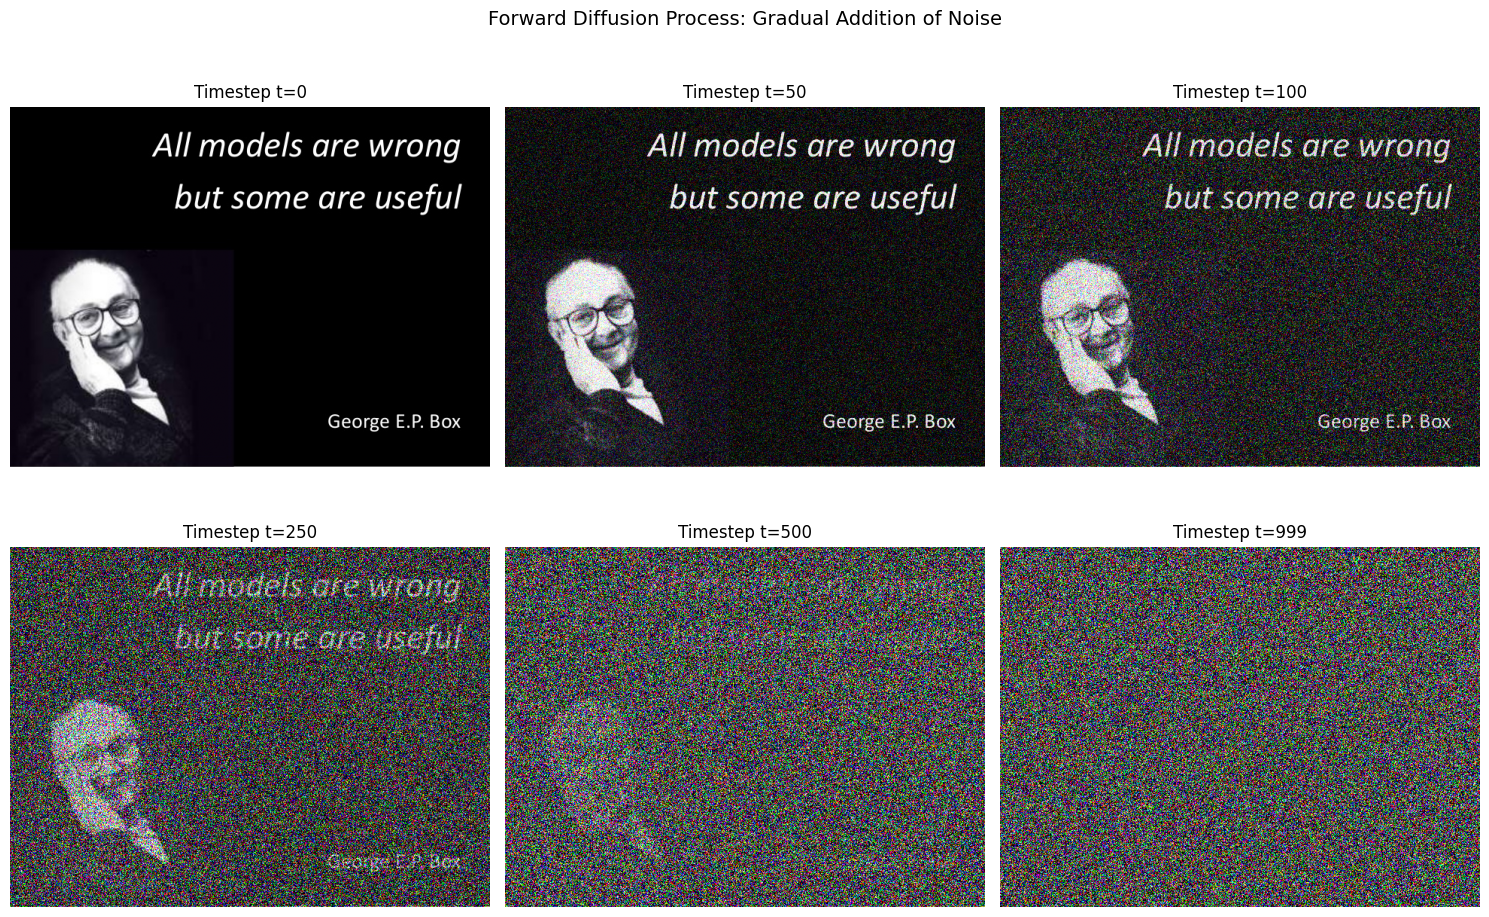

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

# Set random seed for reproducibility
rng = np.random.default_rng(42)
torch.manual_seed(42)


# Simple visualization of the forward diffusion process
# Load the sample image
def load_sample_image(path="../../../img/all_models_are_wrong.jpg"):
    """Load and preprocess an image for demonstration."""
    img = Image.open(path)
    # Convert to numpy array and normalize to [0, 1]
    img = np.array(img) / 255.0
    # Ensure it's RGB (in case it's RGBA or grayscale)
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img


# Create noise schedule (linear)
def create_noise_schedule(timesteps=1000, beta_start=0.0001, beta_end=0.02):
    """Create a linear noise schedule."""
    betas = np.linspace(beta_start, beta_end, timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)
    return betas, alphas, alphas_cumprod


# Forward diffusion: add noise to image
def forward_diffusion(x0, t, alphas_cumprod):
    """Add noise to image at timestep t."""
    # x0: original image, shape (H, W, C)
    # t: timestep (scalar)
    alpha_t = alphas_cumprod[t]
    # Generate random noise
    noise = rng.normal(size=x0.shape)
    # Noisy image
    x_t = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
    return x_t, noise


# Visualize the forward process
img = load_sample_image()
timesteps = 1000
_, _, alphas_cumprod = create_noise_schedule(timesteps)

# Select specific timesteps to visualize
steps_to_show = [0, 50, 100, 250, 500, 999]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, t in enumerate(steps_to_show):
    if t == 0:
        noisy_img = img
    else:
        noisy_img, _ = forward_diffusion(img, t, alphas_cumprod)
    # Clip values for display
    noisy_img_display = np.clip(noisy_img, 0, 1)
    axes[idx].imshow(noisy_img_display)
    axes[idx].set_title(f"Timestep t={t}")
    axes[idx].axis("off")

plt.suptitle("Forward Diffusion Process: Gradual Addition of Noise", fontsize=14)
plt.tight_layout()
plt.show()


### _Reverse Diffusion_

Het omgekeerde process is waardoor de eigenlijke generatie gebeurt. Aan de hand van een neuraal netwerk wordt geleerd om het _forward_ proces om te keren: stapsgewijs de ruis te verwijderen tot tijdstap $0$ bereikt is.

```
Pure Ruis → [- ruis] → ... → [- ruis] → Nieuw Beeld
    xₜ         xₜ₋₁              x₁           x₀
```

Het netwerk wordt getraind om bij elke stap $t$ de additieve ruis te voorspellen, gegeven:
- Het huidige geruis beeld $x_t$
- De tijdstap $t$
- Optioneel: conditionering zoals een tekstbeschrijving

Eens het model in staat is om additieve ruis te voorspellen, kunnen we die voorspelling voor _denoising_ gebruiken (ruis aftrekken van het beeld).

:::{important} Kernidee
Het model leert niet direct beelden te genereren, maar leert hoe ruis eruit ziet op verschillende momenten in het diffusie proces. Door die ruis weg te nemen, komt het onderliggende beeld tevoorschijn.
:::

In recente versies worden bij de _denoising_ niet alle stappen doorlopen, maar geavanceerdere schemas gebruikt om performantie (vooral snelheid) te winnen.

### U-Net backbone
De meeste diffusion modellen zijn gebaseerd op de U-Net CNN architectuur, die oorspronkelijk werd ontwikkeld in de context van medische beeldsegmentatie {cite}`10.48550/arXiv.1505.04597`. De belangrijkste redenen hiervoor zijn:
1. _Skip connections_: Verbinden vroege lagen direct met latere lagen, waardoor zowel lokale details als globale context behouden blijven
2. Encoder-Decoder structuur: 
   - _Encoder_: Comprimeert het beeld naar een lagere resolutie met meer kanalen (abstractere features).
   - _Decoder_: Bouwt het beeld weer op naar originele resolutie.
3. Multi-scale processing: Werkt op verschillende resoluties tegelijk.  
  
[![](https://contributor.insightmediagroup.io/wp-content/uploads/2025/05/1gmDZ4lg5h1LxS1W2USAPjQ.png)](https://arxiv.org/pdf/1505.04597)

Een cruciale aanpassing is dat het netwerk moet weten in welke stap van het diffusie proces het zich bevindt. Dit gebeurt via _sinusoidal positional encoding_. Deze encoding wordt door het hele netwerk geïnjecteerd via _adaptive normalization_ lagen.

### Parameters


### Leeralgoritme

_Diffusion_ modellen worden zoals andere neurale netwerken getraind met varianten van _stochastic gradient descent_ en gebruiken _backpropagation_ om gradiënten te berekenen door het hele netwerk. De _Loss_ functie is bijzonder eenvoudig: de _Mean Squared Error_ tussen echte ruis $\epsilon$ en voorspelde ruis $\epsilon_\theta(x_t, t)$.

$$
\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

:::{note}
:icon: false
Deze eenvoudige loss-functie staat in contrast met GAN en VAE's waar respectievelijk, _adversarial loss_ en _Kullback Leibler divergence_. Diffusion models profiteren daarvan inzake training-stabiliteit, schaalbaarheid en flexibiliteit (gemakkelijk uit te breiden met conditionering).
:::

## Toepassingen

Diffusion models worden gebruikt voor een brede waaier aan toepassingen:

### Text-to-Image
Het genereren van beelden op basis van tekstuele beschrijvingen. Dit is momenteel de meest populaire toepassing.

:::{note} 🌍 DALL-E 2, Stable Diffusion, Midjourney
:icon: false
:class: simple
De bekendste voorbeelden zijn DALL-E 2 (OpenAI), Stable Diffusion (Stability AI), en Midjourney. Deze kunnen foto-realistische beelden genereren uit natuurlijke taal.

[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/stabilityai/stable-diffusion)
:::

### Image-to-Image
Transformatie van beelden naar andere stijlen, het aanpassen van bestaande beelden, of het uitbreiden van beelden.

### Inpainting
Het invullen of vervangen van delen van een beeld op een natuurlijke manier.

### Outpainting
Het uitbreiden van een beeld buiten de oorspronkelijke grenzen.

### Super-resolution
Het verhogen van de resolutie van beelden terwijl details worden toegevoegd.

### Video generatie
Recente ontwikkelingen tonen aan dat diffusion models ook voor video's kunnen gebruikt worden.

:::{note} 🌍 Text-to-Video
:icon: false
:class: dropdown
Modellen zoals Runway's Gen-2 en Stability AI's Stable Video Diffusion kunnen video's genereren uit tekst of bestaande video's transformeren.
:::

In de volgende notebooks zullen we stap voor stap de werking van diffusion models verkennen, gevolgd door concrete implementaties en voorbeelden.